In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,f1_score,precision_score,recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
#loading the data
data = pd.read_csv("bank_data.csv")
#getting the first five observations
data.head()

age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school     NaN      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0         mon  ...         1    999         0  nonexistent          1.1   
1         mon  ...         1    999         0  nonexistent          1.1   
2         mon  ...         1    999         0  nonexistent          1.1   
3         mon  ...         1    999         0  nonexistent          1.1   
4         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [3]:
data.shape
#41188 observation, 21 features

(41188, 21)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
data.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

In [6]:
data['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', nan,
       'entrepreneur', 'student'], dtype=object)

In [7]:
data['job'].value_counts()

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64

<AxesSubplot:>

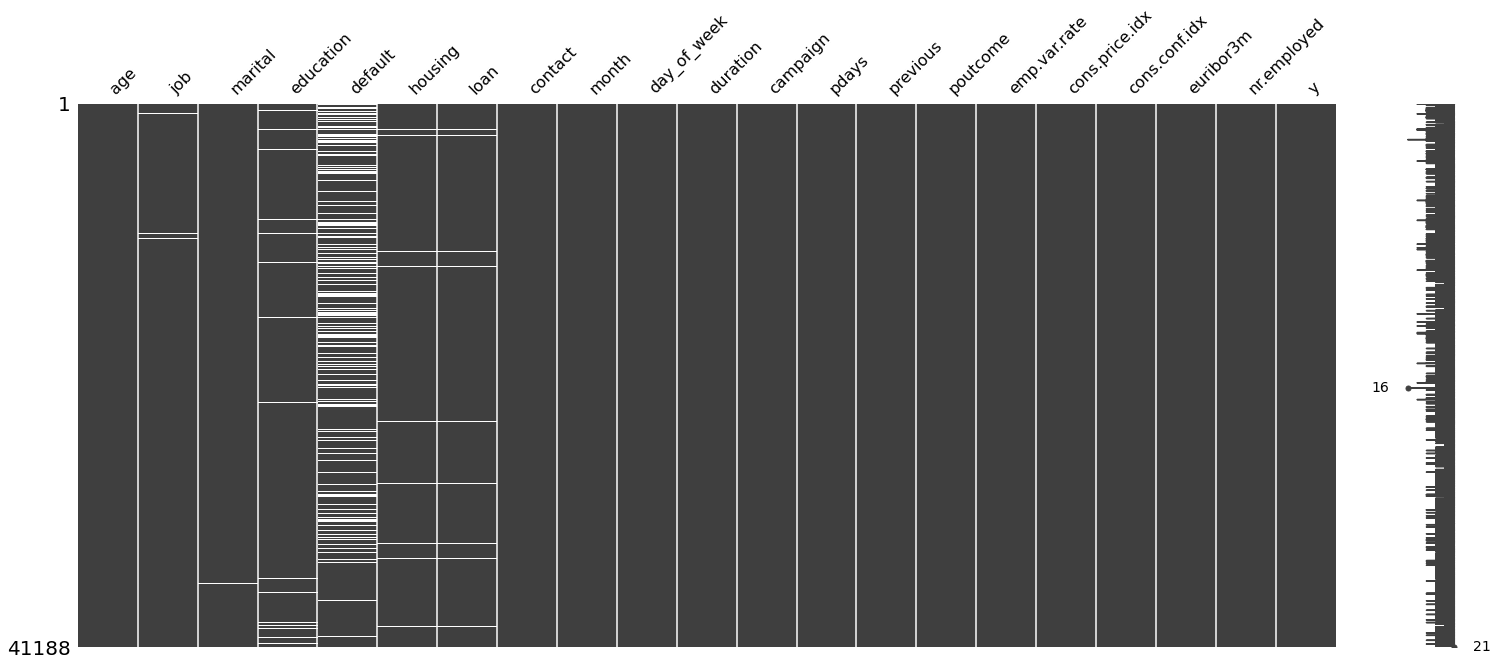

In [8]:
#visualizing matrix of missing data
%matplotlib inline
import missingno as msno
msno.matrix(data)

#### The housing_loan columns relies on the loan column. This explains the equal number of missing values in the two column

In [9]:
bankd = data.copy()

In [10]:
#getting the first five observations
bankd.head()

age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school     NaN      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0         mon  ...         1    999         0  nonexistent          1.1   
1         mon  ...         1    999         0  nonexistent          1.1   
2         mon  ...         1    999         0  nonexistent          1.1   
3         mon  ...         1    999         0  nonexistent          1.1   
4         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

#### The housing_loan should be dropped since it falls under loan column

In [11]:
bankd = bankd.drop('housing',axis=1)

#### The duration should be dropped as it greatly affect the output target

In [12]:
bankd = bankd.drop('duration',axis=1)

In [13]:
bankd['marital'].unique()

array(['married', 'single', 'divorced', nan], dtype=object)

### The dataset is unbalanced so resampling is necessary. Adding more examples to the minority class(oversampling) can reduce the bias in the dataset so I will be filling the missing values with the minority observation in each features

<AxesSubplot:xlabel='marital', ylabel='age'>

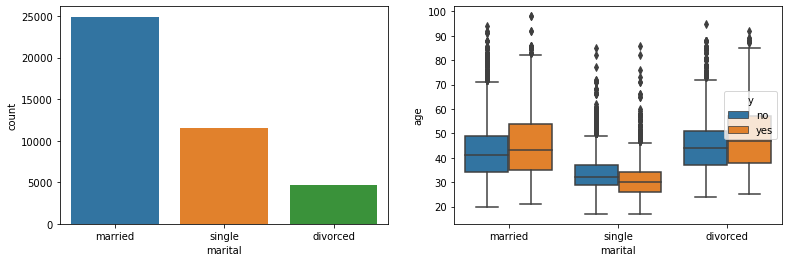

In [14]:
plt.figure(1,figsize=(20,4))
plt.subplot(131)
sns.countplot(x='marital',data=bankd)
plt.subplot(132)
sns.boxplot(x='marital',y='age',data=bankd,hue='y')


#### The married category has the most applicants that subscribed and didn't subscribe for the term deposit

#### The marital features consist of three categories (married,single and divorced). The missing ones can be the 'widowed' and this can still be grouped under 'divorced'

In [15]:
bankd['marital'].fillna('divorced',inplace=True)

In [16]:
bankd['age'].max()

98

<AxesSubplot:xlabel='y', ylabel='age'>

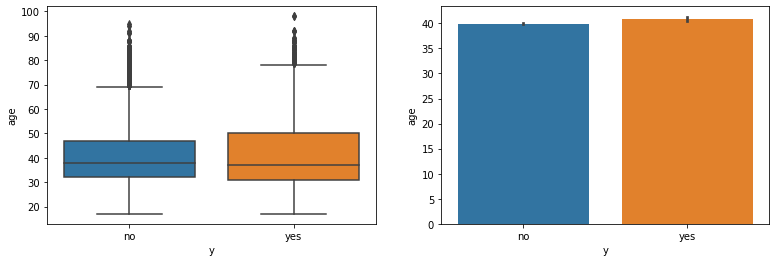

In [17]:
plt.figure(1,figsize=(20,4))
plt.subplot(131)
sns.boxplot(x='y',y='age',data=bankd)
plt.subplot(132)
sns.barplot(x='y',y='age',data=bankd)


In [18]:
bankd['age'].fillna(bankd['age'].mean,inplace=True)

In [19]:
data['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', nan, 'university.degree', 'illiterate'],
      dtype=object)

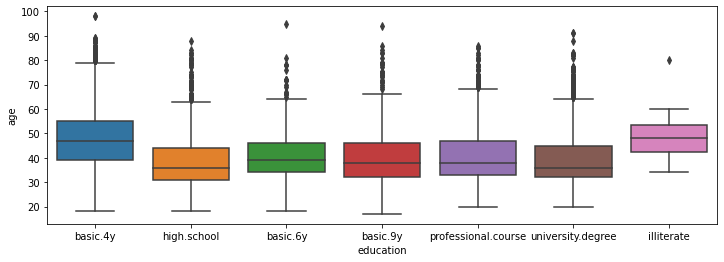

In [20]:
plt.figure(figsize=(12,4))
sns.boxplot(x='education',y='age',data=bankd)
plt.show()

#### The major age with respect to their education levels are; basic.4y(20-80years), high.school(20-65years), basic.6y(20-62years), basic.9y(20-63years), professional course(21-70years), university.degree(21-65years), illiterate(35-60years)

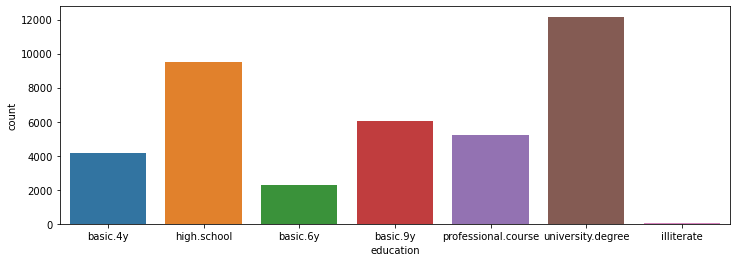

In [21]:
plt.figure(figsize=(12,4))
sns.countplot(x='education',data=bankd)
plt.show()

In [22]:
bankd.groupby('education').count()

age    job  marital  default   loan  contact  month  \
education                                                                    
basic.4y              4176   4124     4176     2477   4059     4176   4176   
basic.6y              2292   2270     2292     1441   2232     2292   2292   
basic.9y              6045   6014     6045     4418   5894     6045   6045   
high.school           9515   9478     9515     7905   9295     9515   9515   
illiterate              18     18       18       11     18       18     18   
professional.course   5243   5231     5243     4438   5118     5243   5243   
university.degree    12168  12123    12168    10718  11891    12168  12168   

                     day_of_week  campaign  pdays  previous  poutcome  \
education                                                               
basic.4y                    4176      4176   4176      4176      4176   
basic.6y                    2292      2292   2292      2292      2292   
basic.9y                    6045      6045   6045      6045      6045   
high.school                 9515      9515   9515      9515      9515   
illiterate                    18        18     18        18        18   
professional.course         5243      5243   5243      5243      5243   
university.degree          12168     12168  12168     12168     12168   

                     emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
education                                                                     
basic.4y                     4176            4176           4176       4176   
basic.6y                     2292            2292           2292       2292   
basic.9y                     6045            6045           6045       6045   
high.school                  9515            9515           9515       9515   
illiterate                     18              18             18         18   
professional.course          5243            5243           5243       5243   
university.degree           12168           12168          12168      12168   

                     nr.employed      y  
education                                
basic.4y                    4176   4176  
basic.6y                    2292   2292  
basic.9y                    6045   6045  
high.school                 9515   9515  
illiterate                    18     18  
professional.course         5243   5243  
university.degree          12168  12168

#### The illiterate category in the education feature has the least occurence(1749) and university.degree has the highest occurence

In [23]:
bankd['education'].fillna('illiterate',inplace=True)

In [24]:
bankd['default'].value_counts()

no     32588
yes        3
Name: default, dtype: int64

<AxesSubplot:xlabel='default', ylabel='count'>

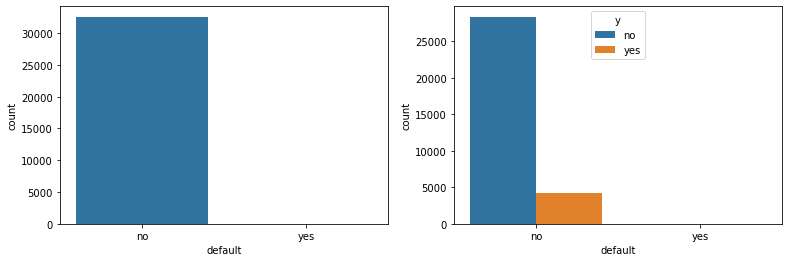

In [25]:
plt.figure(1,figsize=(20,4))
plt.subplot(131)
sns.countplot(x='default',data=bankd)
plt.subplot(132)
sns.countplot(x='default',data=bankd,hue='y')


#### All but three applicants do not have credit in fault(99.9% of the applicants do have credit in default) and about 92% of the 99.9% did not subscribe to a term deposit

In [26]:
bankd['default'].fillna('yes',inplace=True)

In [27]:
bankd['loan'].value_counts()

no     33950
yes     6248
Name: loan, dtype: int64

<AxesSubplot:xlabel='loan', ylabel='count'>

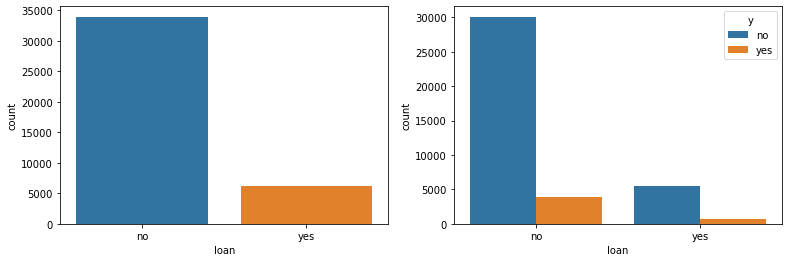

In [28]:
plt.figure(1,figsize=(20,4))
plt.subplot(131)
sns.countplot(x='loan',data=bankd)
plt.subplot(132)
sns.countplot(x='loan',data=bankd,hue='y')


In [29]:
bankd['loan'].fillna('yes',inplace=True)

In [30]:
bankd['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', nan,
       'entrepreneur', 'student'], dtype=object)

<AxesSubplot:xlabel='job', ylabel='count'>

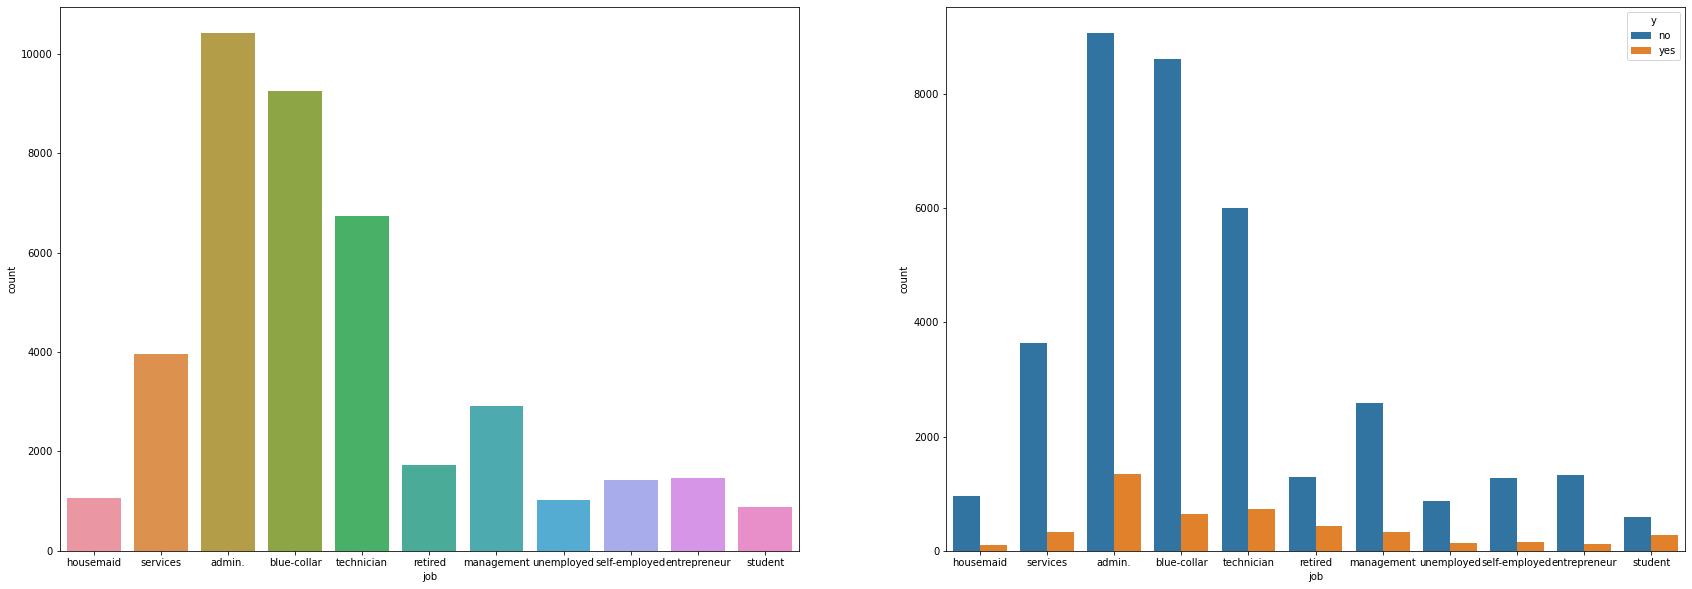

In [31]:
plt.figure(1,figsize=(45,10))
plt.subplot(131)
sns.countplot(x='job',data=bankd)
plt.subplot(132)
sns.countplot(x='job',data=bankd,hue='y')

In [32]:
bankd['job'].fillna('unemployed',inplace=True) #filling the missing values with 'unemployed'

In [33]:
bankd.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [34]:
bankd.columns

Index(['age', 'job', 'marital', 'education', 'default', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')

In [35]:
dummy = pd.get_dummies(bankd[['month','job','education','contact','day_of_week','poutcome']])

In [36]:
new_data = pd.DataFrame(bankd[['age','pdays', 'previous','campaign','emp.var.rate', 
                              'cons.price.idx', 'cons.conf.idx','euribor3m', 'nr.employed','default','loan','y']])

In [37]:
new_data['y'] = new_data['y'].map({'yes':1,'no':0})
new_data['default'] = new_data['default'].map({'yes':1,'no':0})
new_data['loan'] = new_data['loan'].map({'yes':1,'no':0})

In [38]:
det = pd.DataFrame(new_data[['default','loan','y']])
new_data = pd.concat([new_data,dummy],axis=1)
new_data = pd.concat([new_data,det],axis=1)

In [39]:
new_data.head()

age  pdays  previous  campaign  emp.var.rate  cons.price.idx  \
0   56    999         0         1           1.1          93.994   
1   57    999         0         1           1.1          93.994   
2   37    999         0         1           1.1          93.994   
3   40    999         0         1           1.1          93.994   
4   56    999         0         1           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  default  ...  day_of_week_mon  \
0          -36.4      4.857       5191.0        0  ...                1   
1          -36.4      4.857       5191.0        1  ...                1   
2          -36.4      4.857       5191.0        0  ...                1   
3          -36.4      4.857       5191.0        0  ...                1   
4          -36.4      4.857       5191.0        0  ...                1   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  poutcome_failure  \
0                0                0                0                 0   
1                0                0                0                 0   
2                0                0                0                 0   
3                0                0                0                 0   
4                0                0                0                 0   

   poutcome_nonexistent  poutcome_success  default  loan  y  
0                     1                 0        0     0  0  
1                     1                 0        1     0  0  
2                     1                 0        0     0  0  
3                     1                 0        0     0  0  
4                     1                 0        0     1  0  

[5 rows x 53 columns]

In [40]:
new_data.columns

Index(['age', 'pdays', 'previous', 'campaign', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'default', 'loan', 'y', 'month_apr', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'contact_cellular', 'contact_telephone', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'default', 'loan', 'y'],
      dtype='object')

In [41]:
corr = new_data.corr()
corr

age     pdays  previous  campaign  \
age                            1.000000 -0.034369  0.024365  0.004594   
pdays                         -0.034369  1.000000 -0.587514  0.052584   
previous                       0.024365 -0.587514  1.000000 -0.079141   
campaign                       0.004594  0.052584 -0.079141  1.000000   
emp.var.rate                  -0.000371  0.271004 -0.420489  0.150754   
cons.price.idx                 0.000857  0.078889 -0.203130  0.127836   
cons.conf.idx                  0.129372 -0.091342 -0.050936 -0.013733   
euribor3m                      0.010767  0.296899 -0.454494  0.135133   
nr.employed                   -0.017725  0.372605 -0.501333  0.144095   
default                        0.165019  0.080072 -0.102533  0.032923   
loan                          -0.007224  0.000737 -0.000504  0.004831   
y                              0.030399 -0.324914  0.230181 -0.066357   
month_apr                      0.014285 -0.009629  0.079384 -0.058519   
month_aug                      0.065309 -0.003176 -0.048852  0.015009   
month_dec                      0.046563 -0.076425  0.059557 -0.009819   
month_jul                     -0.043563  0.049695 -0.116785  0.098385   
month_jun                     -0.009532  0.015957 -0.069905  0.070144   
month_mar                      0.008390 -0.078769  0.072733 -0.015244   
month_may                     -0.067523  0.070690 -0.012534 -0.032704   
month_nov                      0.030045 -0.016946  0.081050 -0.079028   
month_oct                      0.053008 -0.128677  0.127754 -0.049126   
month_sep                      0.040889 -0.154629  0.157651 -0.033953   
job_admin.                    -0.102584 -0.025398  0.018888  0.011745   
job_blue-collar               -0.024191  0.065335 -0.054845 -0.001775   
job_entrepreneur               0.031213  0.019246 -0.013239 -0.002203   
job_housemaid                  0.085403 -0.001649 -0.011569  0.004226   
job_management                 0.062040  0.000254  0.006735 -0.009135   
job_retired                    0.440772 -0.072084  0.065113 -0.006847   
job_self-employed             -0.001356  0.014307 -0.011231  0.006361   
job_services                  -0.065731  0.030573 -0.011885  0.002383   
job_student                   -0.199749 -0.096367  0.104671 -0.024657   
job_technician                -0.064383  0.004575 -0.017142  0.001557   
job_unemployed                 0.020111 -0.025864  0.005671  0.001142   
education_basic.4y             0.244079  0.005804 -0.017601  0.004000   
education_basic.6y             0.009897  0.023238 -0.021493 -0.000991   
education_basic.9y            -0.038320  0.036963 -0.026418 -0.005278   
education_high.school         -0.106550  0.005522  0.014347  0.000195   
education_illiterate           0.070905 -0.022122  0.022258  0.001925   
education_professional.course  0.002054 -0.003493 -0.007631  0.002554   
education_university.degree   -0.071138 -0.036958  0.025419 -0.000950   
contact_cellular              -0.007021 -0.117970  0.212848 -0.077368   
contact_telephone              0.007021  0.117970 -0.212848  0.077368   
day_of_week_fri                0.007148  0.013782  0.004404  0.026641   
day_of_week_mon                0.019027  0.001031 -0.002012  0.014405   
day_of_week_thu               -0.021356 -0.008186  0.001512  0.005141   
day_of_week_tue                0.019137 -0.007300  0.000090 -0.025125   
day_of_week_wed               -0.023671  0.001021 -0.003929 -0.021088   
poutcome_failure              -0.002537  0.006354  0.682608 -0.068890   
poutcome_nonexistent          -0.016376  0.491353 -0.878776  0.087645   
poutcome_success               0.035626 -0.950700  0.524045 -0.050893   
default                        0.165019  0.080072 -0.102533  0.032923   
loan                          -0.007224  0.000737 -0.000504  0.004831   
y                              0.030399 -0.324914  0.230181 -0.066357   

                               emp.var.rate  cons.price.idx  cons.conf.idx  \
age            

<AxesSubplot:>

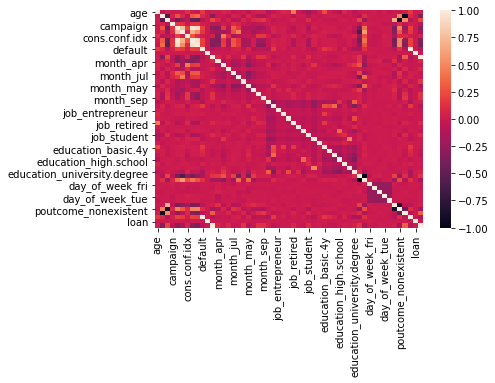

In [42]:
sns.heatmap(corr)

#### Removing columns with correlation greater than 0.9

In [43]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = new_data.columns[columns]
new_data = new_data[selected_columns]

In [44]:
new_data.shape #two columns have been dropped

(41188, 51)

In [45]:
new_data.columns

Index(['age', 'pdays', 'previous', 'campaign', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'default', 'default', 'loan', 'loan',
       'y', 'y', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'contact_cellular', 'contact_telephone', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success'],
      dtype='object')

#### 'euribor3m' and  'nr.employed' features do to their high positive correlation

In [46]:
new_data.head()

age  pdays  previous  campaign  emp.var.rate  cons.price.idx  \
0   56    999         0         1           1.1          93.994   
1   57    999         0         1           1.1          93.994   
2   37    999         0         1           1.1          93.994   
3   40    999         0         1           1.1          93.994   
4   56    999         0         1           1.1          93.994   

   cons.conf.idx  default  default  loan  ...  contact_cellular  \
0          -36.4        0        0     0  ...                 0   
1          -36.4        1        1     0  ...                 0   
2          -36.4        0        0     0  ...                 0   
3          -36.4        0        0     0  ...                 0   
4          -36.4        0        0     1  ...                 0   

   contact_telephone  day_of_week_fri  day_of_week_mon  day_of_week_thu  \
0                  1                0                1                0   
1                  1                0                1                0   
2                  1                0                1                0   
3                  1                0                1                0   
4                  1                0                1                0   

   day_of_week_tue  day_of_week_wed  poutcome_failure  poutcome_nonexistent  \
0                0                0                 0                     1   
1                0                0                 0                     1   
2                0                0                 0                     1   
3                0                0                 0                     1   
4                0                0                 0                     1   

   poutcome_success  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 51 columns]

In [47]:
x = new_data.iloc[:,:-1].values
y = new_data.iloc[:,-1].values

In [48]:
x_train,x_test,y_train,y_test =  train_test_split(x,y, test_size=0.3,random_state=42)
x_train_val,x_test_val,y_train_val,y_test_val = train_test_split(x_train,y_train,random_state=42)
       

In [49]:
model_pipeline = Pipeline([
    ('std_scaler',StandardScaler()),
    ('lrg_reg',LogisticRegression())
])

In [50]:
model_pipeline.fit(x_train_val,y_train_val)

pred = model_pipeline.predict(x_train_val)
accuracy_score(y_train_val,pred)

1.0

In [51]:
val_pred = model_pipeline.predict(x_test_val)
accuracy_score(y_test_val,val_pred)

1.0

In [52]:
y_pred = model_pipeline.predict(x_test)
accuracy_score(y_test,y_pred)

1.0

### using XGBClassfier

In [53]:
bg = XGBClassifier(use_label_encoder=False,)
bg.fit(x_train_val,y_train_val)
st = bg.predict_proba(x_train_val)[:,1]
roc_auc_score(y_train_val,st)

[13:20:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1.0

In [54]:
st_pred = bg.predict_proba(x_test_val)[:,1]
roc_auc_score(y_test_val,st_pred)

1.0

In [55]:
test_pred = bg.predict_proba(x_test)[:,1]
roc_auc_score(y_test,test_pred)

1.0